# Using bandits to learn probabilities for the search space

To learn probabilities for the search space, the `Brush` estimators (not the DEAP!) uses a multi-armed bandit approach. 

This allows it to dynamically adjust the sampling probabilities of different operations based on their performance.

Not only it can learn how to sample terminals, but it also learns which mutations are useful and which are not. This is also important, as the mutations are responsible for sampling from the search space.

In this notebook, we show how to set this configuration, and how it changes the probabilities.

In [1]:
import pandas as pd
from pybrush import Dataset, SearchSpace
from pybrush import BrushRegressor

df = pd.read_csv('../examples/datasets/d_enc.csv')
X = df.drop(columns='label')
y = df['label']

data = Dataset(X,y)

search_space = SearchSpace(data)

This is the original search space using the loaded dataset. 

In [2]:
print( search_space.print() )

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x_5", "x_7", "1.00"], "ArrayF": ["x_0", "x_1", "x_2", "x_3", "x_4", "x_6", "1.00"]}
terminal_weights: {"ArrayB": [1], "ArrayI": [0.014733159, 0.037457366, 0.026095262], "ArrayF": [0.6343385, 0.67299956, 0.42711574, 0.8625447, 0.8957853, 0.20750472, 0.6167148]}
node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Pow] = 1.00*Pow, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Div] = 1.00*Div, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Logistic] = 1.00*Logistic, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Square] = 1.00*Square, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Sqrta

There are two important settings for this:

- `bandit`, which specifies which strategy will be used to learn the probabilities, and
- `weights_init`, which will initialize the sampling probabilities for terminals in the search space based on the correlation between each terminal and the target variable.

In [3]:
est = BrushRegressor(
    functions=['SplitOn','Add','Exp','Sub', 'SplitBest',
               'Mul','Sin','Cos','Exp','Logabs'],
    max_gens=100,
    pop_size=100,
    max_stall=20,
    objectives=["scorer", "linear_complexity"],
    
    # Changing search space sampling probabilities
    bandit='thompson',
    weights_init=True,
    use_arch=False,
    
    verbosity=1
)

In [4]:
est.fit(X,y)

Completed  96% [=================== ]saving final population as archive...


BrushRegressor(algorithm='nsga2', bandit='thompson', batch_size=1.0,
               constants_simplification=True, cx_prob=0.14285714285714285,
               functions=['SplitOn', 'Add', 'Exp', 'Sub', 'SplitBest', 'Mul',
                          'Sin', 'Cos', 'Exp', 'Logabs'],
               inexact_simplification=True, initialization='uniform',
               load_population='', logfile='', max_depth=10, max_gens=100,
               max_size=100, max_stall=20, max_ti...
                               'point': 0.16666666666666666,
                               'subtree': 0.16666666666666666,
                               'toggle_weight_off': 0.16666666666666666,
                               'toggle_weight_on': 0.16666666666666666},
               n_jobs=1, num_islands=5,
               objectives=['scorer', 'linear_complexity'], pop_size=100,
               random_state=None, save_population='', scorer='mse',
               sel='lexicase', shuffle_split=False, surv='nsga2',
               use_arch=False, val_from_arch=True, ...)

In [5]:
from sklearn.metrics import root_mean_squared_error

y_pred = est.predict(X)
print('R2 score:', est.score(X,y))
print('RMSE    :', root_mean_squared_error(y, y_pred))

R2 score: 0.9503088822701279
RMSE    : 2.1192778599130486


model: Add(If(x0>0.75,If(x0>0.81,3.72*x4,0.24*x3),0.02*x1),Add(19.40*x6,If(x0>0.75,3.27*Sin(0.08*x1),-8.93*x6)))


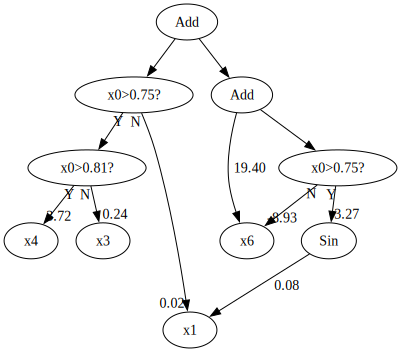

In [6]:
import graphviz

print('model:', est.best_estimator_.get_model())

model = est.best_estimator_.get_model("dot")
graphviz.Source(model)

The attribute `search_space_` is an original copy and it is not changed.

In [7]:
est.search_space_.print()

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x5", "x7", "1.00"], "ArrayF": ["x0", "x1", "x2", "x3", "x4", "x6", "1.00"]}
terminal_weights: {"ArrayB": [1], "ArrayI": [0.014733159, 0.037457366, 0.026095262], "ArrayF": [0.6343385, 0.67299956, 0.42711574, 0.8625447, 0.8957853, 0.20750472, 0.6167148]}
node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 1
node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Logabs] = 1.00*Logabs, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Exp] = 1.00*Exp, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Sin] = 1.00*Sin, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Cos] = 1.00*Cos, weight = 1
node_map[MatrixF][["ArrayF", "ArrayF", "A

When we call `fit`, the Brush engine is set to run and return the best individual. Then, the engine is stored as an attribute in our estimator, called `engine_`, and we can retrieve the learned probabilities by looking at the engine's search space.

In [8]:
est.engine_.search_space.print()

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x5", "x7", "1.00"], "ArrayF": ["x0", "x1", "x2", "x3", "x4", "x6", "1.00"]}
terminal_weights: {"ArrayB": [0.3329473], "ArrayI": [0.3809668, 0.47323334, 0.5664852], "ArrayF": [0.033086747, 0.08362485, 0.06368329, 0.059957452, 0.07092283, 0.045770478, 0.07865266]}
node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 0.31536424
node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 0.46593833
node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 0.6326896
node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 0.0353554
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Logabs] = 1.00*Logabs, weight = 0.7454892
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Exp] = 1.00*Exp, weight = 0.3469734
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Sin] = 1.00*Sin, weight = 0.5367735
node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][C

Mutation probabilities are stored in the parameters, not the search space. The same way that we can have the original and the learned probabilities by looking at the instance references and the instance's engine reference, we can look the learned probabilities.

In [9]:
print(est.parameters_.cx_prob)
print(est.parameters_.mutation_probs)

0.1428571492433548
{'delete': 0.1666666716337204, 'insert': 0.1666666716337204, 'point': 0.1666666716337204, 'subtree': 0.1666666716337204, 'toggle_weight_off': 0.1666666716337204, 'toggle_weight_on': 0.1666666716337204}


In [10]:
print(est.engine_.params.cx_prob)
print(est.engine_.params.mutation_probs)

0.09370556473731995
{'delete': 0.07188443094491959, 'insert': 0.054662108421325684, 'point': 0.23181933164596558, 'subtree': 0.517862856388092, 'toggle_weight_off': 0.14806653559207916, 'toggle_weight_on': 0.052384451031684875}


## Comparing convergences

In the code below we run a simple experiment using the evolution log to compare convergence curves using different types of bandits

In [11]:
import tempfile

# Running 5x each algorithm and saving its convergence data
bandits = ['dummy', 'thompson', 'linear_thompson', 'dynamic_thompson']
results = {b:[] for b in bandits}

with tempfile.TemporaryDirectory() as tmpdirname:
    for bandit in bandits:
        print(f"Running bandit: {bandit}")
        for run in range(5):
            logfile = f"{tmpdirname}/log_bandit={bandit}_run={run}.csv"
            
            est = BrushRegressor(
                functions=['SplitOn','Add','Exp','Sub', 'SplitBest',
                        'Mul','Sin','Cos','Exp','Logabs'],
                max_gens=50,
                pop_size=100,
                max_stall=50, # avoiding early stopping --- we want to see the full convergence
                objectives=["scorer", "linear_complexity"],
                bandit=bandit,
                weights_init=True,
                use_arch=False,
                logfile=logfile,
                verbosity=1
            ).fit(X,y)

            results[bandit] .append({'run'       : run,
                                    'model'      : est.best_estimator_.get_model(),
                                    'size'       : est.best_estimator_.fitness.size,
                                    'loss_v'     : est.best_estimator_.fitness.loss_v,
                                    'complexity' : est.best_estimator_.fitness.complexity,
                                    'log'        : pd.read_csv(logfile) }) # loading logfile and saving it

Running bandit: dummy
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Running bandit: thompson
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Running bandit: linear_thompson
Completed 100% [====================]
saving final population as archive...
Completed 100% [====================]
saving final population as archive...
Completed

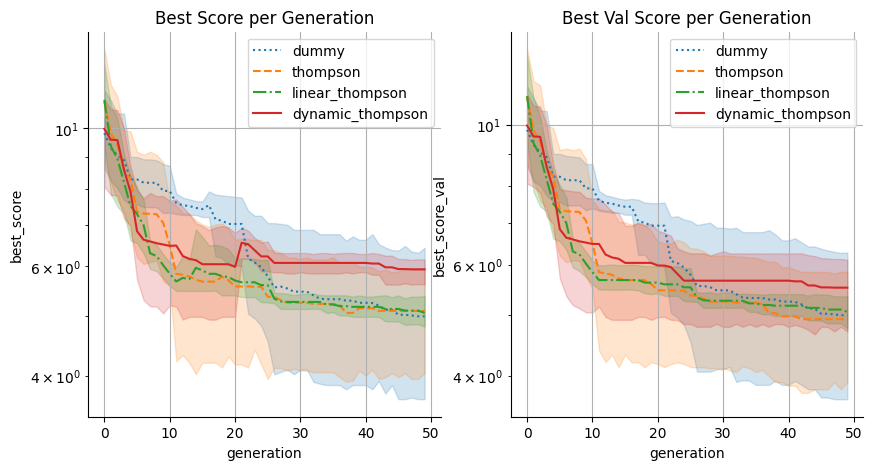

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

lines = [":","--","-.", "-"]
linecycler = cycle(lines)

for i, col in enumerate(['best_score', 'best_score_val']):
    for bandit in bandits:
        bandit_df = pd.concat([experiment['log'] for experiment in results[bandit]], axis=0)
        sns.lineplot(bandit_df, x='generation', y=col, ls=next(linecycler), label=bandit, ax=axs[i], estimator=np.mean)
    sns.despine()
    axs[i].grid()
    axs[i].set_yscale('log')

axs[0].set_title('Best Score per Generation')
axs[1].set_title('Best Val Score per Generation')
plt.legend()

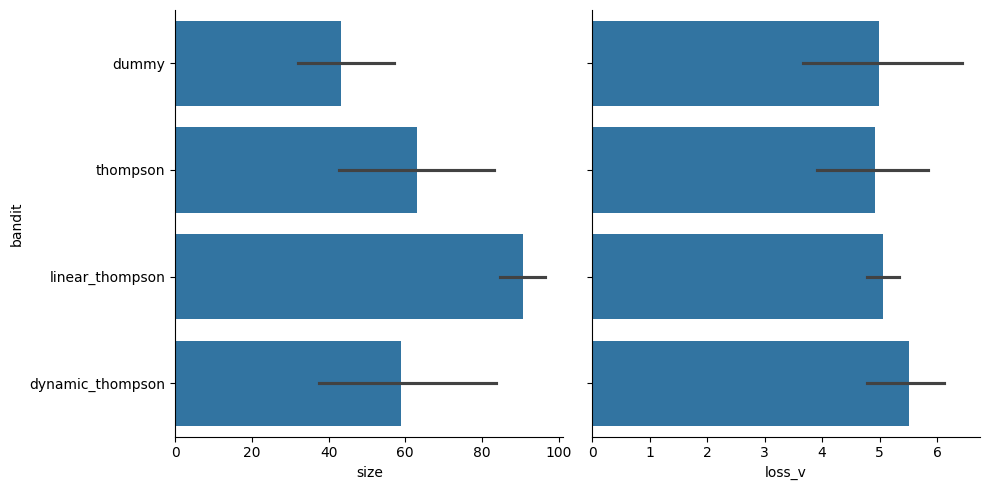

In [13]:
frames = []
for bandit in bandits:
    for experiment in results[bandit]:
        frames.append({
            'bandit'        : bandit,
            'run'           : experiment['run'],
            'model'         : experiment['model'],
            'size'          : experiment['size'],
            'loss_v'        : experiment['loss_v'],
            'complexity'    : experiment['complexity']
        })

df = pd.DataFrame(frames)


fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, col in enumerate(['size', 'loss_v']):
    sns.barplot(df, y='bandit', x=col, ax=axs[i])
    sns.despine()
    
plt.tight_layout()